# Face recognition using neural network features

In this task, you have to construct face recognizer based on features extracted from the neural network. The task consists of two parts: image classification and video classification. In the first one you should classify distinct images and in the second one you will deal with short video sequences.

In [1]:
from keras.models import Model, Sequential, load_model
from keras.layers import Flatten, Dense, Activation
from keras.layers import Convolution2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


In [2]:
%pylab inline
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
from copy import copy
from collections import Counter
from skimage.transform import resize
import skimage

Populating the interactive namespace from numpy and matplotlib


First of all, you have you have to read the data. Run the cell below to unpack data.

In [3]:
from get_data import unpack
unpack('Face_Recognition_data.zip')

### Reading data for image and video classification (1 point)

Implement function $\tt{load}$\_$\tt{image}$\_$\tt{data}$. It should return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing ones. The keys of the dictionaries are the names of the image files and the values are 3-dimensional numpy arrays (for images) or strings with the names (for labels).

$\tt{dir}$\_$\tt{name}$ is the name of directory with data for image classification. If 'Face_Recofnition_data' directory is located in the same directory as this notebook, then the default value can be used.

In [4]:
import glob

def load_image_data(dir_name = 'Face_Recognition_data/image_classification'):
    
    # read labels
    def read_csv(filename):
        with open(filename, 'r') as f:
            file_label_list = f.read().split('\n')[1:-1]
            return {l[0]:l[1] for l in [line.split(',') for line in file_label_list]}
        
    train_labels = read_csv(dir_name+'/train/y_train.csv')
    test_labels = read_csv(dir_name+'/test/y_test.csv')
    
    # read images
    train_images = {os.path.basename(f):cv2.imread(f)[:,:,[2,1,0]] for f in glob.glob(dir_name+'/train/images/*.jpg')}
    test_images = {os.path.basename(f):cv2.imread(f)[:,:,[2,1,0]] for f in glob.glob(dir_name+'/test/images/*.jpg')}
    
    return train_images, train_labels, test_images, test_labels

In [5]:
x_train, y_train, x_test, y_test = load_image_data()
print('%d'%len(x_train), '\ttraining images')
print('%d'%len(x_test), '\ttesting images')

661 	training images
808 	testing images


In [6]:
def visualize(data, labels, function = lambda x:x[0], n_cols = 5, n_rows=1):
    figure(figsize = (3*n_cols,3*n_rows))
    for n,i in enumerate(np.random.choice(list(data.keys()), size = n_cols*n_rows)):
        plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        plt.imshow(function([data[i]]))
        plt.title(labels[i])
    plt.show()

That is how the data looks like.

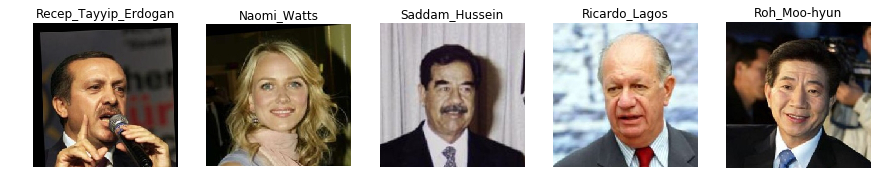

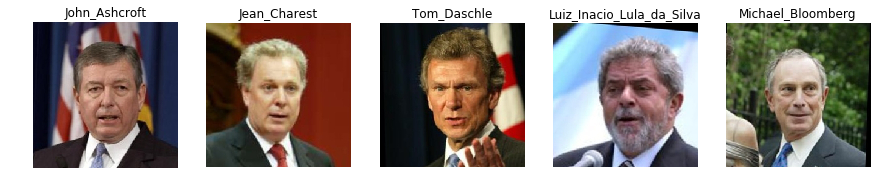

In [7]:
visualize(x_train, y_train)
visualize(x_test, y_test)

Let us now read the video classification data, as well. You have to implement function to load video data.

Function $\tt{load}$\_$\tt{video}$\_$\tt{data}$ should also return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing videos and labels. The training data is in the same format as in image classification task. The keys of testing data and labels are video ids and the values are the lists of frames and the strings with names, respectively.

In [192]:
def load_video_data(dir_name = 'Face_Recognition_data/video_classification'):

    # read labels
    def read_csv(filename):
        with open(filename, 'r') as f:
            file_label_list = f.read().split('\n')[1:-1]
            return {l[0]:l[1] for l in [line.split(',') for line in file_label_list]}
        
    train_labels = read_csv(dir_name+'/train/y_train.csv')
    test_labels = read_csv(dir_name+'/test/y_test.csv')
    
    
    # read images (these are not freaking videos)
    train_images = {os.path.basename(f):cv2.imread(f)[:,:,[2,1,0]] for f in glob.glob(dir_name+'/train/images/*.jpg')}
    test_images = {os.path.basename(f):[cv2.imread(v)[:,:,[2,1,0]] for v in glob.glob(f+'/*')] \
                   for f in glob.glob(dir_name+'/test/videos/*')}
    
    return train_images, train_labels, test_images, test_labels

In [193]:
video_train, train_labels, video_test, test_labels = load_video_data()
print('%d'%len(video_train), '\ttraining images')
print('%d'%len(video_test), '\ttesting videos')

729 	training images
70 	testing videos


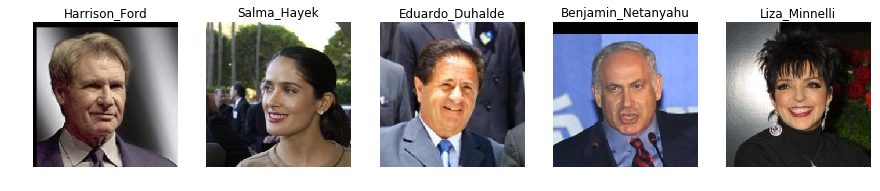

In [194]:
visualize(video_train, train_labels)

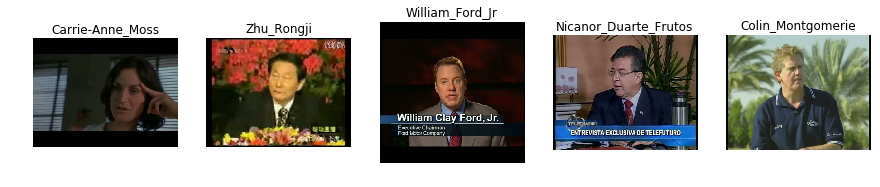

In [195]:
visualize({i:video_test[i][1] for i in video_test}, test_labels)

### Preprocessing (3 points)
You have to implement preprocessing function in the cell below.
Getting a list of images as an input the this function should detect the face on each image, find the facial keypoints () and then crop and normalize the image according to these keypoints. The output of this function is the list of images which contain only the aligned face and should be converted to the tensor of the shape $(N, 224, 224, 3)\ $ where $N$ is the length of the initial list. You can add extra arguments to the preprocess function if necessary (i.e. flag $\tt{is}$\_$\tt{video}$ to determine if the list of images is video sequence or not).

For face detection and facial keypoint regression you can use your models from the previous tasks.

In [75]:
import warnings
warnings.filterwarnings("ignore")

def transform_face(image, eyes):
    # pad image
    borders = [100]*4
    image_with_border = cv2.copyMakeBorder(image, *borders, cv2.BORDER_CONSTANT, value=(0,0,0))
    eyes[0] += 100
    eyes[1] += 100

    # get angle between eyes in degrees
    angle_rad = math.atan2(eyes[0][1]-eyes[1][1], eyes[0][0]-eyes[1][0])
    angle_deg = math.degrees(angle_rad)
    
    # rotate image around leftmost eye
    rotated_image = skimage.transform.rotate(image_with_border, angle_deg-180, center=eyes[0])
    
    # make padding
    borders = [100]*4
    rotated_with_border = cv2.copyMakeBorder(rotated_image, *borders, cv2.BORDER_CONSTANT, value=(0,0,0))
    
    # calculate new position of rightmost eye
    eyes_dist = np.sqrt(np.square(eyes[0][1]-eyes[1][1])+np.square(eyes[0][0]-eyes[1][0]))
    eye_1 = (eyes[0][1]+eyes_dist, int(np.array(eyes[0][0])))
    eye_0 = (eyes[0][1], eyes[0][0])
    
    # calculate a box around the eyes
    cY, cX = int(eye_0[1]), int(eye_0[0]+(eyes_dist/2))
    d = int(eyes_dist*1.75)
    cN = d//3
    top = cY-d+cN
    bot = cY+d+cN
    lef = cX-d
    rig = cX+d
    
    top = max(0,top)
    bot = min(bot, rotated_image.shape[0])
    lef = max(0,lef)
    rig = min(rig, rotated_image.shape[1])
    
    # crop to box
    cropped = rotated_image[top:bot, lef:rig]
       
    # resize to 224x244
    final_img = resize(cropped, (224,224,3))
    
    return final_img

In [76]:
def preprocess_imgs(imgs):
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    keypoint_model = load_model('facial_keypoint_model.h5', compile=False)
    
    cropped_faces = []

    for i, img in enumerate(imgs):
        print('{} / {}'.format(i+1, len(imgs)), end='\r')

        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 10)
        if (len(faces) > 0) and (len(faces[0] == 4)):
            x,y,w,h = faces[0]
            roi = img[y+10:y+h+20, x-5:x+w+5] # modify roi because keypoint model expects eyebrows near top and visible chin
            if roi.size > 0:
                roi = cv2.resize(roi, (100,100)).astype(np.float32) / 255
                keypoints = keypoint_model.predict(roi[None]).reshape((14,2))
                eye_left = (keypoints[5] + 0.5)*roi.shape[:2]+(y+10, x-5)
                eye_right = (keypoints[8] + 0.5)*roi.shape[:2]+(y+10, x-5)
                cropped_faces.append(transform_face(img, [eye_left, eye_right]))
            else:
                cropped_faces.append(np.zeros_like(cropped_faces[-1]))
        else:
            cropped_faces.append(np.zeros_like(cropped_faces[-1]))
        
    return np.array(cropped_faces)

#### Visualization of preprocessing

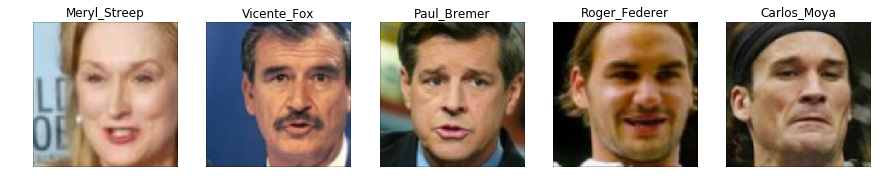

In [77]:
visualize(x_train, y_train, function = lambda x:preprocess_imgs(x)[0])

The neural network is already trained on the other face dataset. You should use this network as feature extractor to get descriptors of the faces. You can choose any hidden layer you need (or several layers) to extract features and any classification method.

In [27]:
import h5py
from keras.models import load_model
model = load_model('face_recognition_model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 56, 56, 256)       295168    
__________

Here is an example of using the network as feature extractor. The shape of input tensor has to be (n_images, 224, 224, 3), so you can input several images simultaneously and get their face descriptors of shape (n_images, n_components).

In [78]:
def get_layer_output(images, layer = 'fc6'):
    assert len(images.shape)==4, 'Wrong input dimentionality!'
    assert images.shape[1:]==(224,224,3), 'Wrong input shape!'
    
    network_output = model.get_layer(layer).output
    feature_extraction_model = Model(model.input, network_output)
    
    output = feature_extraction_model.predict(images)
    return output

In [79]:
img = cv2.resize(x_train['0.jpg'], (224,224)).reshape(1,224,224,3)
out = get_layer_output(img)
print(out.shape)

(1, 4096)


### Training classifier (2 points)


You have to implement class $\tt{Classifier}$ with methods $\tt{fit}$, $\tt{classify}$\_$\tt{images}$ and $\tt{classify}$\_$\tt{videos}$ in the cell below. 
The method $\tt{Classifier.fit}$ gets two dictionaries as input: train images and labels, and trains the classifier to predict the person shown on the image.
$\tt{Classifier.classify}$\_$\tt{images}$ gets the dictionary of test images (with filenames as keys) as input and should return the dictionary of the predicted labels.
$\tt{Classifier.classify}$\_$\tt{videos}$ is similar to the previous one, but gets the dictionary of test videos (with video as keys) as input.

To classify video you can combine the predictions for its frames any way you want (averaging, voting, etc.).
If video classification takes too long you can use face detector not in all the frames but every few frames while preprocessing video frames. 
Besides, sometimes the face is hardly detected on the image and the frame in which the detector works wrong can add noise to the prediction. Hence, the result of the prediction without using such frames may be better.

In [188]:
from sklearn.neighbors import KNeighborsClassifier as kNN
from skimage.io import imread
import cv2
from os.path import join
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, ReLU, Lambda
from keras import backend as K

class Classifier():
    def __init__(self, nn_model=None):
        self.clf = None

    def preprocess_images(self, images, keys):
        imgs = [images[k] for k in keys]
        print('Detecting faces...')
        faces = preprocess_imgs(imgs)
        print('Getting descriptors...')
        return get_layer_output(faces)
    
    def fit_dnn(self, X, y):
        model = Sequential()
        model.add(Dense(512, input_shape=[X.shape[-1]]))
        model.add(BatchNormalization())
        model.add(ReLU())
        model.add(Dropout(0.25))
        model.add(Dense(256))
        model.add(BatchNormalization())
        model.add(ReLU())
        model.add(Dropout(0.25))
        model.add(Dense(128))
        model.add(BatchNormalization())
        model.add(ReLU())
        model.add(Dropout(0.25))
        model.add(Dense(64))
        model.add(BatchNormalization())
        model.add(ReLU())
        model.add(Dropout(0.25))
        model.add(Dense(y.shape[-1]))
        model.add(Lambda(lambda x: K.tf.nn.softmax(x)))
        model.compile(optimizer='Adam', loss='categorical_crossentropy')
        model.fit(X, y, batch_size=32, epochs=250)
        self.clf = model
    
    def fit(self, train_imgs, train_labels):
        keys = list(train_imgs.keys())
        y_raw = [train_labels[k] for k in keys]
        self.encoder = LabelBinarizer().fit(y_raw)
        y = self.encoder.transform(y_raw)
        X = self.preprocess_images(train_imgs, keys)
        print('Fitting classifier...')
        #self.clf = kNN(3).fit(X, y)
        self.fit_dnn(X, y)
        print('Done')

    def classify_images(self, test_imgs):
        if self.clf is not None:
            keys = list(test_imgs.keys())
            preds = self.clf.predict(self.preprocess_images(test_imgs, keys))
            names = self.encoder.inverse_transform(preds)
            return {k:n for k,n in zip(keys,names)}
        else:
            return None
       
    def classify_videos(self, test_video):
        keys = list(test_video.keys())
        y = {}
        for k in keys:
            imgs = test_video[k]
            faces = preprocess_imgs(imgs)
            descriptors = get_layer_output(faces)
            preds = self.clf.predict_proba(descriptors)
            sum_probs = preds.sum(axis=0)
            high_prob = np.argmax(sum_probs)
            sparse = np.zeros_like(sum_probs)
            sparse[high_prob] = 1
            name = self.encoder.inverse_transform(sparse[None])
#             unique, pos = np.unique(names, return_inverse=True)
#             counts = np.bincount(pos)
#             y[k] = names[counts.argmax()]
            y[k] = name
        return y

Now we can build the classifier, fit it and use to predict the labels of testing images.

In [184]:
img_classifier = Classifier(model)
img_classifier.fit(x_train, y_train)
y_out = img_classifier.classify_images(x_test)

Detecting faces...
Getting descriptors...
Fitting classifier...
Epoch 1/250
780/780 [==============================] - 15s 20ms/step - loss: 4.6078
Epoch 2/250
780/780 [==============================] - 1s 691us/step - loss: 4.0950
Epoch 3/250
780/780 [==============================] - 1s 692us/step - loss: 3.7060
Epoch 4/250
780/780 [==============================] - 1s 688us/step - loss: 3.4919
Epoch 5/250
780/780 [==============================] - 1s 695us/step - loss: 3.2173
Epoch 6/250
780/780 [==============================] - 1s 698us/step - loss: 2.9893
Epoch 7/250
780/780 [==============================] - 1s 690us/step - loss: 2.7831
Epoch 8/250
780/780 [==============================] - 1s 694us/step - loss: 2.6521
Epoch 9/250
780/780 [==============================] - 1s 692us/step - loss: 2.3803
Epoch 10/250
780/780 [==============================] - 1s 695us/step - loss: 2.2142
Epoch 11/250
780/780 [==============================] - 1s 686us/step - loss: 2.0219
Epoch 12/2

780/780 [==============================] - 1s 695us/step - loss: 0.1264
Epoch 192/250
780/780 [==============================] - 1s 697us/step - loss: 0.1101
Epoch 193/250
780/780 [==============================] - 1s 695us/step - loss: 0.1102
Epoch 194/250
780/780 [==============================] - 1s 693us/step - loss: 0.1173
Epoch 195/250
780/780 [==============================] - 1s 700us/step - loss: 0.0928
Epoch 196/250
780/780 [==============================] - 1s 695us/step - loss: 0.1335
Epoch 197/250
780/780 [==============================] - 1s 689us/step - loss: 0.1180
Epoch 198/250
780/780 [==============================] - 1s 691us/step - loss: 0.1075
Epoch 199/250
780/780 [==============================] - 1s 700us/step - loss: 0.0956
Epoch 200/250
780/780 [==============================] - 1s 693us/step - loss: 0.0984
Epoch 201/250
780/780 [==============================] - 1s 698us/step - loss: 0.0933
Epoch 202/250
780/780 [==============================] - 1s 688us/st

### Image classification quality (2 points)

Let us check the accuracy of your classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.90, to obtain 2 points — at least 0.95.

In [139]:
def check_test(output, gt):
    correct = 0.
    total = len(gt)
    for k, v in gt.items():
        if output[k] == v:
            correct += 1
    accuracy = correct / total

    return 'Classification accuracy is {:.4f}'.format(accuracy)

In [185]:
print(check_test(y_out, y_test))

Classification accuracy is 0.9554


### Video classification quality (2 points)

Let us check the quality of video classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.80, to obtain 2 points — at least 0.85.

In [196]:
video_classifier = Classifier(model)
video_classifier.fit(video_train, train_labels)

Detecting faces...
Getting descriptors...
Fitting classifier...
Epoch 1/250
729/729 [==============================] - 18s 24ms/step - loss: 4.5726
Epoch 2/250
729/729 [==============================] - 1s 726us/step - loss: 4.0126
Epoch 3/250
729/729 [==============================] - 1s 724us/step - loss: 3.6529
Epoch 4/250
729/729 [==============================] - 1s 742us/step - loss: 3.3823
Epoch 5/250
729/729 [==============================] - 1s 736us/step - loss: 3.1049
Epoch 6/250
729/729 [==============================] - 1s 733us/step - loss: 2.8743
Epoch 7/250
729/729 [==============================] - 1s 726us/step - loss: 2.6456
Epoch 8/250
729/729 [==============================] - 1s 733us/step - loss: 2.4342
Epoch 9/250
729/729 [==============================] - 1s 731us/step - loss: 2.2985
Epoch 10/250
729/729 [==============================] - 1s 727us/step - loss: 2.1236
Epoch 11/250
729/729 [==============================] - 1s 721us/step - loss: 1.9204
Epoch 12/2

729/729 [==============================] - 1s 733us/step - loss: 0.0799
Epoch 192/250
729/729 [==============================] - 1s 736us/step - loss: 0.0963
Epoch 193/250
729/729 [==============================] - 1s 725us/step - loss: 0.0789
Epoch 194/250
729/729 [==============================] - 1s 727us/step - loss: 0.0949
Epoch 195/250
729/729 [==============================] - 1s 732us/step - loss: 0.0743
Epoch 196/250
729/729 [==============================] - 1s 730us/step - loss: 0.1131
Epoch 197/250
729/729 [==============================] - 1s 723us/step - loss: 0.0796
Epoch 198/250
729/729 [==============================] - 1s 731us/step - loss: 0.0667
Epoch 199/250
729/729 [==============================] - 1s 729us/step - loss: 0.0883
Epoch 200/250
729/729 [==============================] - 1s 728us/step - loss: 0.0776
Epoch 201/250
729/729 [==============================] - 1s 741us/step - loss: 0.0699
Epoch 202/250
729/729 [==============================] - 1s 734us/st

In [197]:
y_video_out = video_classifier.classify_videos(video_test)

In [198]:
print(check_test(y_video_out, test_labels))

Classification accuracy is 0.5571
